# Mapas Coropléticos en Python (GeoPandas + PySAL)

Este cuaderno explica, de forma **práctica y matemática**, cómo construir mapas coropléticos:
- cómo elegir la **variable** correcta (tasas vs. conteos),
- cómo **clasificar** los datos (intervalos, cuantiles, Jenks/Fisher–Jenks),
- cómo estimar el **número de clases** con la **regla de Freedman–Diaconis**


## Requisitos

Este cuaderno usa librerías de SIG en Python:

- `geopandas` (lectura/plot de datos espaciales)
- `mapclassify` (esquemas de clasificación para coropletas)
- `libpysal` y `esda` (autocorrelación espacial)
- `matplotlib` y `numpy`



In [1]:
# !pip install geopandas mapclassify libpysal esda matplotlib numpy shapely pyproj


In [2]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import mapclassify as mc
from libpysal.weights import Queen
from esda.moran import Moran

# Evitar warnings visuales y asegurar estilo simple
plt.rcParams['figure.figsize'] = (8, 6)


## Fundamentos matemáticos mínimos

### Asignación de clases
Sea una variable cuantitativa asociada a cada polígono $i$, denotada por $y_i$.
Dividimos el dominio de $y$ en clases $C_j$ con límites $(c_j, c_{j+1})$ tales que

$$
c_j < y_i \le c_{j+1} \quad \forall\, y_i \in C_j, \quad j=1,\dots,k.
$$

### Regla de Freedman–Diaconis (FD) para el ancho de clase
Para un conjunto de datos unidimensional \(y\) de tamaño \(n\), el **ancho** óptimo se aproxima por

$$
w \;=\; 2 \cdot IQR(y) \cdot n^{-1/3},
$$

donde $IQR = Q_3 - Q_1$. Si usamos $w$ para particionar el rango $(\min(y), \max(y))$, el **número de clases** propuesto es

$$
k \;=\;  \frac{\max(y) - \min(y)}{w}.
$$



## Dataset público: *Natural Earth* (incluido en GeoPandas)

Usaremos el conjunto **`naturalearth_lowres`** (países del mundo) que viene con GeoPandas.  
Calcularemos **PIB per cápita** como variable de ejemplo y generaremos varios mapas coropléticos.


In [3]:
# Cargar Natural Earth (incluido en GeoPandas, no requiere internet)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Limpiezas mínimas
world = world[(world.pop_est > 0) & (world.name != 'Antarctica')].copy()

# Variable de ejemplo: PIB per cápita en USD (gdp_md_est está en millones)
world['gdp_pc'] = (world['gdp_md_est'] * 1_000_000) / world['pop_est']

world[['name', 'continent', 'pop_est', 'gdp_md_est', 'gdp_pc']].head()


/var/folders/kg/plkd97154_zf916xg8gj219h0000gn/T/ipykernel_4352/3023982553.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,name,continent,pop_est,gdp_md_est,gdp_pc
0,Fiji,Oceania,889953.0,5496,6175.607026
1,Tanzania,Africa,58005463.0,63177,1089.156033
2,W. Sahara,Africa,603253.0,907,1503.515109
3,Canada,North America,37589262.0,1736425,46194.708478
4,United States of America,North America,328239523.0,21433226,65297.517508


## Visualización base de la variable

Antes de clasificar, inspeccionemos la distribución de `gdp_pc` para entender su sesgo y valores extremos.


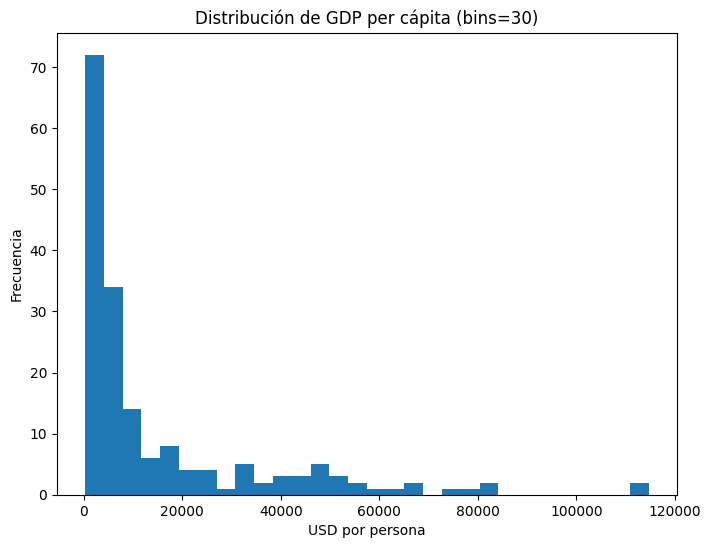

In [4]:
x = world['gdp_pc'].dropna().values

fig = plt.figure()
plt.hist(x, bins=30)
plt.title('Distribución de GDP per cápita (bins=30)')
plt.xlabel('USD por persona'); plt.ylabel('Frecuencia')
plt.show()


### Número de clases propuesto por Freedman–Diaconis

Calculamos \(w\) y \(k\) siguiendo la regla FD y usamos ese \(k\) como punto de partida para un mapa con **intervalos iguales**.


In [5]:
def freedman_diaconis_k(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = x.size
    if n < 2:
        return 1
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    w = 2 * iqr * n ** (-1/3)
    if w <= 0:
        return int(np.sqrt(n))  # fallback
    k = int(np.ceil((x.max() - x.min()) / w))
    return max(1, min(k, 12))  # limitar por legibilidad

k_fd = freedman_diaconis_k(world['gdp_pc'].values)
k_fd


12

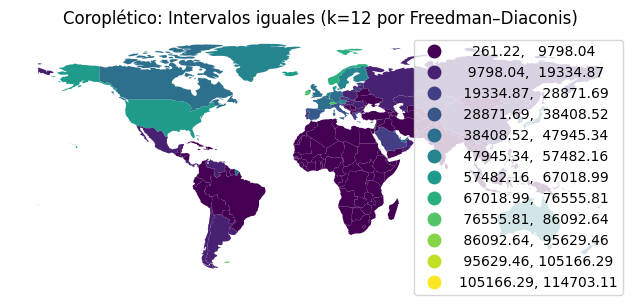

In [6]:
# Mapa con intervalos iguales usando k de FD
ax = world.plot(column='gdp_pc',
                scheme='equal_interval',
                k=k_fd,
                legend=True)
ax.set_title(f'Coroplético: Intervalos iguales (k={k_fd} por Freedman–Diaconis)')
ax.set_axis_off()
plt.show()


## Comparación de esquemas de clasificación

Mostramos **tres** esquemas populares (mismo `k` para comparar):
- **`quantiles`**: cada clase contiene ~el mismo número de polígonos.
- **`equal_interval`**: clases con el mismo ancho en el eje de valores.
- **`FisherJenks`** (*Jenks*): minimiza la varianza intra-clase y maximiza la inter-clase.


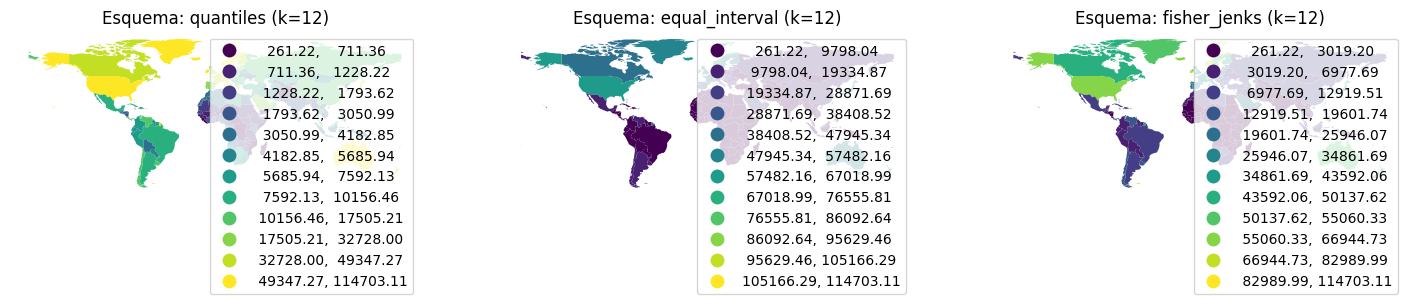

In [7]:
schemes = ['quantiles', 'equal_interval', 'fisher_jenks']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, scheme in zip(axes, schemes):
    world.plot(column='gdp_pc', scheme=scheme, k=k_fd, legend=True, ax=ax)
    ax.set_title(f'Esquema: {scheme} (k={k_fd})')
    ax.set_axis_off()

plt.show()


## Tasas vs. conteos (¡evitar sesgos visuales!)

En coropletas se deben mapear **tasas/razones** (p. ej., *PIB per cápita*), **no conteos brutos** (*PIB total*), para no confundir **tamaño del área** con **intensidad** del fenómeno.

Sea $z_i$ un conteo y $a_i$ una población/área base; entonces una tasa típica es

$$
r_i \;=\; \frac{z_i}{a_i}.
$$

En este cuaderno usamos `gdp_pc` (*PIB per cápita*) en lugar de `gdp_md_est`.


## Sensibilidad al número de clases \(k\)

Compara cómo cambia el mapa al variar \(k\). No existe un \(k\) universal; FD da un **punto de partida** razonable.


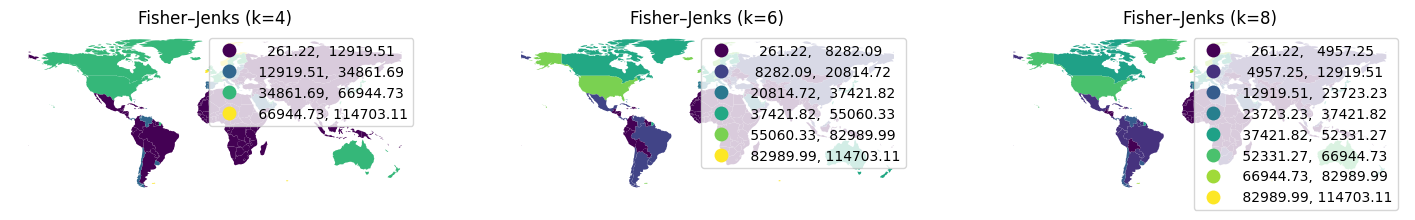

In [8]:
ks = [4, 6, 8]
fig, axes = plt.subplots(1, len(ks), figsize=(18, 5))
for ax, k in zip(axes, ks):
    world.plot(column='gdp_pc', scheme='fisher_jenks', k=k, legend=True, ax=ax)
    ax.set_title(f'Fisher–Jenks (k={k})')
    ax.set_axis_off()
plt.show()
